In [1]:
import pandas as pd
import muon as mu
import scanpy as sc
from muon import atac as ac
import numpy as np
import warnings
import pychromvar as pc
import sys
import os

/root/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_dir = os.path.abspath('')
data_path = os.path.join(file_dir, '..', '..', 're_design', '10x_data')

h5_file_path = os.path.join(data_path, 'pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5')
ann_file_path = os.path.join(data_path, "pbmc_granulocyte_sorted_3k_atac_peak_annotation.tsv")
genome_file_path = os.path.join(data_path, 'refdata-gex-GRCh38-2020-A','fasta', 'genome.fa')
save_path = os.path.join(file_dir, 'generated_data')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mdata = mu.read_10x_h5(h5_file_path)

mdata.var_names_make_unique()

Added `interval` annotation for features from /workspaces/projects/re_diffusion/data_utils/../../re_design/10x_data/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5


# QC

In [8]:
# annotate the group of mitochondrial genes as 'mt'
mdata['rna'].var['mt'] = mdata['rna'].var_names.str.startswith('MT-')
# Compute QC metrics for RNA
sc.pp.calculate_qc_metrics(mdata['rna'], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

mu.pp.filter_var(mdata['rna'], 'n_cells_by_counts', lambda x: x >= 3)
mu.pp.filter_obs(mdata['rna'], 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
mu.pp.filter_obs(mdata['rna'], 'total_counts', lambda    x: x < 15000)
mu.pp.filter_obs(mdata['rna'], 'pct_counts_mt', lambda x: x < 20)

# Compute QC metrics for ATAC
sc.pp.calculate_qc_metrics(mdata['atac'], percent_top=None, log1p=False, inplace=True)
# Filter ATAC based on quality metrics
mu.pp.filter_var(mdata['atac'], 'n_cells_by_counts', lambda x: x >= 50)
mu.pp.filter_obs(mdata['atac'], 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
mu.pp.filter_obs(mdata['atac'], 'total_counts', lambda x: (x >= 4000) & (x <= 40000))
# Intersect observations to keep only cells present in both modalities
mu.pp.intersect_obs(mdata)

# Normalize

In [9]:
mdata['rna'].layers["counts"] = mdata['rna'].X.copy()
sc.pp.normalize_total(mdata['rna'], target_sum=1e4)
sc.pp.log1p(mdata['rna'])

sc.pp.highly_variable_genes(mdata['rna'], min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pp.scale(mdata['rna'], max_value=10)
sc.tl.pca(mdata['rna'], svd_solver='arpack')

mdata['atac'].layers["counts"] = mdata['atac'].X
# Transform peak counts with TF-IDF (Term Frequency - Inverse Document Frequency)
ac.pp.tfidf(mdata['atac'], scale_factor=None)
# Run Latent Semantic Indexing
ac.tl.lsi(mdata['atac'])

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


# Annotation merge

In [10]:
# # read cellranger peak annotation with vectorized interval creation
# peak_annotation = pd.read_csv(ann_file_path, sep='\t')
# peak_annotation['interval'] = peak_annotation['chrom'] + ':' + peak_annotation['start'].astype(str) + '-' + peak_annotation['end'].astype(str)

# # using groupby to handle duplicates and aggregate values
# aggregated = peak_annotation.groupby('interval').agg({
# 'gene': lambda x: list(x.dropna().astype(str)),
# 'distance': lambda x: list(map(str, x.dropna())),
# 'peak_type': lambda x: list(x.dropna().astype(str))
# }).reset_index()

# # merge directly 

# mdata['atac'].var = pd.merge(mdata['atac'].var, aggregated, on='interval', how='left')
# mdata.mod['atac'].var_names = mdata.mod['atac'].var.interval

In [6]:
peak_annotation = pd.read_csv(ann_file_path, sep='\t')
# Parse peak annotation file and add it to the .uns[“atac”][“peak_annotation”]
ac.tl.add_peak_annotation(mdata, peak_annotation)

/root/.local/lib/python3.10/site-packages/muon/_atac/tools.py:118: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pa.loc[pa.distance.isnull(), "distance"] = ""
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7feb8eb57190>>
Traceback (most recent call last):
  File "/root/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


# Add peak sequence

In [11]:
mdata['atac'].X = mdata['atac'].layers["counts"]
# adds mdata['atac'].uns['peak_seq']
pc.add_peak_seq(mdata, genome_file=genome_file_path, delimiter=":|-")

100%|██████████| 62871/62871 [00:08<00:00, 7355.94it/s]


In [12]:
mdata['atac'].var['peak_seq'] = mdata.mod['atac'].uns['peak_seq']

# Create gene cluster connection based on combined modality and rank genes

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


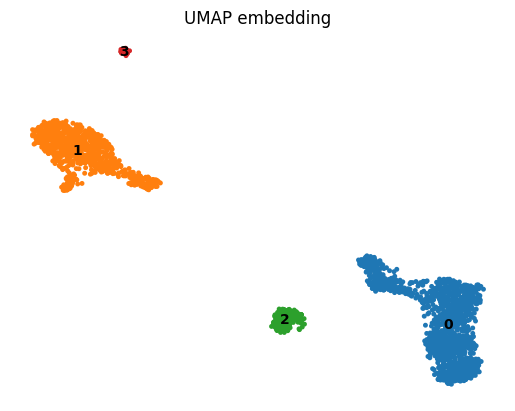

In [9]:
# # compute the neighbors for only rna
# sc.pp.neighbors(mdata['rna'], n_neighbors=200)
# # compute the neighbors for only atac
# sc.pp.neighbors(mdata['atac'], use_rep="X_lsi", n_neighbors=200)
# mu.pp.neighbors(mdata, key_added='wnn')
# mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)

# # cluster the cells with leiden
# sc.tl.leiden(mdata, resolution=.05, neighbors_key='wnn', key_added='leiden_wnn')
# # plot
# mu.pl.umap(mdata, color=['leiden_wnn'], frameon=False, title="UMAP embedding", legend_loc="on data")

# mdata['rna'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']
# # rank the differentially expressed genes  
# sc.tl.rank_genes_groups(mdata.mod['rna'], 'leiden_wnn', method='wilcoxon')
# # transform into format gene,cluster and take only statistically significant
# from collections import defaultdict 

# filter_by_pvalue = pd.DataFrame(mdata.mod['rna'].uns['rank_genes_groups']['pvals_adj'])<0.05
# de_rna = pd.DataFrame(mdata.mod['rna'].uns['rank_genes_groups']['names'])[filter_by_pvalue]
# pvalues = pd.DataFrame(mdata.mod['rna'].uns['rank_genes_groups']['pvals_adj'])[filter_by_pvalue]
# gene_cluster_pvalues  = defaultdict(dict)
# # flatten into list of unique genes in format gene:cluster 
# for idx, row in de_rna.iterrows():
#     for cluster, gene in enumerate(row):
#         if gene:
#             gene_cluster_pvalues[gene][int(cluster)] = pvalues.iloc[idx,cluster]

# gene_cluster = {}

# for gene, cluter_dict in gene_cluster_pvalues.items():
#     # choose cluster with minimum p-value
#     gene_cluster[gene] = min(cluter_dict, key=cluter_dict.get)

# Create gene cluster connection based on ATAC and peaks

... storing 'feature_types' as categorical
... storing 'genome' as categorical
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


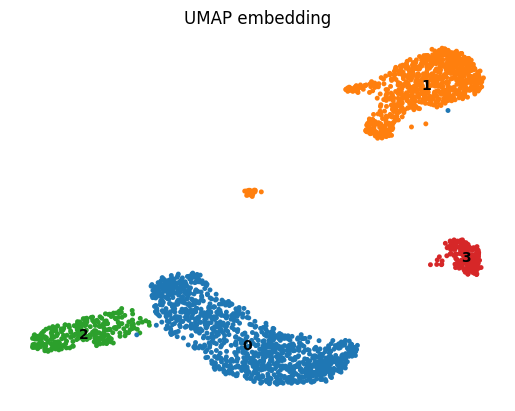

In [13]:
# compute the neighbors for only atac
sc.pp.neighbors(mdata['atac'], use_rep="X_lsi", n_neighbors=100, key_added='wnn')
sc.tl.umap(mdata.mod['atac'], neighbors_key='wnn', random_state=10)
sc.tl.leiden(mdata.mod['atac'], resolution=.05, neighbors_key='wnn', key_added='leiden_wnn')
# plot
mu.pl.umap(mdata['atac'], color=['leiden_wnn'], frameon=False, title="UMAP embedding", legend_loc="on data")

In [14]:
# rank the differentially expressed genes  
sc.tl.rank_genes_groups(mdata.mod['atac'], 'leiden_wnn', method='wilcoxon')

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [24]:
# transform into format peak,cluster and filter by p-value and take only first n
from collections import defaultdict 
rank_peak_groups = mdata.mod['atac'].uns['rank_genes_groups']
filter_by_pvalue = pd.DataFrame(rank_peak_groups['pvals_adj'])<0.05
de_rna = pd.DataFrame(rank_peak_groups['names'])[filter_by_pvalue].iloc[1:10000,:]
peak_cluster  = defaultdict(list)
# flatten into list of unique genes in format gene:cluster 
for _, row in de_rna.iterrows():
    for cluster, peak in enumerate(row):
        if cluster is not None and cluster not in peak_cluster[peak]:
            peak_cluster[peak].append(cluster)

In [42]:
print("Total peaks:", len(peak_cluster), "; more than 1 cluster peaks:",sum([len(x)>1 for x in peak_cluster.values()]))

Total peaks: 62861 ; more than 1 cluster peaks: 2414


# Final dataset based on genes

In [52]:
# # take annonation data
# ann_data = mdata.mod['atac'].uns['atac']['peak_annotation']
# # get gene as column not index
# ann_data = ann_data.reset_index()
# # merge atac modality with annotation based on peak id in format chr#:start-end
# full_data = mdata['atac'].var.merge( ann_data, left_on='interval', right_on='peak', how='left')
# # subset only required columns
# full_data = full_data[['peak','gene','peak_type','peak_seq']]
# # get chromosome column
# full_data['chrom'] = full_data['peak'].apply(lambda x: x.split(':')[0])
# # new column cluster by mapping genes to cluster with help of gene_cluster dict
# full_data['cell_type'] = full_data['gene'].map(gene_cluster)
# # clean
# full_data = full_data[full_data.cell_type.notna()]

# full_data['cell_type'] = "ct"+(full_data.cell_type.astype(int)+1).astype(str)

# # for data constitencty with legacy code
# full_data.rename(columns={'peak_type':'peaktype','peak_seq':'sequence'}, inplace=True)
# full_data

# Final dataset based on ATAC peaks

In [27]:
full_data = mdata['atac'].var.reset_index(drop=True)

# subset only required columns
full_data = full_data[['interval','peak_seq']]
# get chromosome column
full_data['chrom'] = full_data['interval'].apply(lambda x: x.split(':')[0])
# filter out unmapped peaks
full_data  = full_data[full_data['chrom'].str.contains('chr')]
# new column cluster by mapping genes to cluster with help of gene_cluster dict
full_data['cell_type'] = full_data['interval'].map(peak_cluster)
full_data = full_data.explode('cell_type')
full_data = full_data[full_data.cell_type.notna()]

full_data['cell_type'] = "ct"+(full_data.cell_type.astype(int)+1).astype(str)
full_data.reset_index(drop=True,inplace=True)
# for data constitencty with legacy code
full_data.rename(columns={'peak_seq':'sequence', 'interval':'peak'}, inplace=True)
full_data

,peak,sequence,chrom,cell_type
0,chr1:633556-634476,TATGACCCACCATAATTACCCCCATACTCCTTACACTATTCCTCAT...,chr1,ct4
1,chr1:816877-817780,CAAAAGCAGCAGTGGAAAAAGACCATACTATTCAATATATGGTGTT...,chr1,ct2
2,chr1:844149-845034,CAGACACATACAGAGGGACGATCGTGTGAGGACACAGAGGATGGCA...,chr1,ct1
3,chr1:869472-870376,CTATCTATCTACCTGCCTATCATCTATCTATCTATTTACTATCTAT...,chr1,ct4
4,chr1:869472-870376,CTATCTATCTACCTGCCTATCATCTATCTATCTATTTACTATCTAT...,chr1,ct1
...,...,...,...,...
27228,chrX:154733963-154734867,CTAACACTTTGAAGAGTGTACCTTTTTTTTGGCAAGGTGATGTTAG...,chrX,ct3
27229,chrX:155070886-155071794,GAGTTGTACGAGATTCGGGGGCTGTGACTTGGAAATAAAACAAAAT...,chrX,ct4
27230,chrX:155188576-155189458,TATTGCTTTATGAGTTCTATACAAATTCTGGATACTATTCCTTTGT...,chrX,ct1
27231,chrX:155242153-155243061,GCTTTAGAAGCCATAAGGGACCACCCTCTTTTTAACAGTTCCCTGT...,chrX,ct2


In [53]:
print("Total peaks:", full_data.shape[0],"; more than 1 cluster:" ,full_data[full_data['peak'].duplicated()].shape[0])

Total peaks: 27233 ; more than 1 cluster: 2535


In [31]:
np.random.seed(10)
train_data=full_data.sample(frac=0.5)
test_data=full_data.drop(train_data.index)

In [32]:
print(train_data['cell_type'].value_counts())
print(train_data['chrom'].value_counts())

cell_type
ct1    5060
ct2    4983
ct4    2454
ct3    1119
Name: count, dtype: int64
chrom
chr1     1329
chr2      979
chr19     876
chr6      821
chr17     815
chr3      742
chr12     736
chr11     725
chr10     651
chr7      629
chr5      620
chr16     570
chr9      563
chr8      523
chr14     462
chr4      452
chr15     442
chr20     427
chr22     357
chr13     276
chrX      243
chr18     214
chr21     164
Name: count, dtype: int64


In [33]:
print(test_data['cell_type'].value_counts())
print(test_data['chrom'].value_counts())

cell_type
ct2    5016
ct1    4935
ct4    2513
ct3    1153
Name: count, dtype: int64
chrom
chr1     1358
chr2     1018
chr17     845
chr19     833
chr3      808
chr6      806
chr12     724
chr11     701
chr10     613
chr7      605
chr5      604
chr9      558
chr16     549
chr8      533
chr4      504
chr14     500
chr15     429
chr20     419
chr22     349
chr13     268
chr18     223
chrX      202
chr21     168
Name: count, dtype: int64


In [125]:
pd.DataFrame(full_data[['cell_type','chrom']].groupby('cell_type').value_counts()).sort_index()

count
cell_type chrom       
ct1       chr1    2381
          chr10   1122
          chr11   1288
          chr12   1325
          chr13    495
...                ...
ct4       chr6     372
          chr7     256
          chr8     229
          chr9     225
          chrX      56

[92 rows x 1 columns]

In [34]:
print("File statistics")
print(full_data['cell_type'].value_counts())
print(full_data['chrom'].value_counts())

File statistics
cell_type
ct2    9999
ct1    9995
ct4    4967
ct3    2272
Name: count, dtype: int64
chrom
chr1     2687
chr2     1997
chr19    1709
chr17    1660
chr6     1627
chr3     1550
chr12    1460
chr11    1426
chr10    1264
chr7     1234
chr5     1224
chr9     1121
chr16    1119
chr8     1056
chr14     962
chr4      956
chr15     871
chr20     846
chr22     706
chr13     544
chrX      445
chr18     437
chr21     332
Name: count, dtype: int64


In [37]:
full_data['sequence'].str.len().describe()

count    27233.000000
mean       865.605809
std         77.835002
min        239.000000
25%        855.000000
50%        889.000000
75%        907.000000
max       1567.000000
Name: sequence, dtype: float64

In [35]:
file_name = os.path.join(save_path, 'newpeak_promoter-distal_seq_peak_class.csv')

full_data.to_csv(file_name, index=False)

In [61]:
temp = []
for c, df in full_data[full_data["chrom"]=="chr2"].groupby('cell_type'):
    if c == 'ct1':
        temp = df

In [63]:
num_sequences = 1000
seq_to_subset_comp = True
if num_sequences is not None and seq_to_subset_comp and num_sequences < temp.shape[0]:
    num_to_sample = num_sequences
else:
    num_to_sample = temp.shape[0]

In [64]:
num_to_sample

741

In [66]:
temp.sample(num_to_sample)

,peak,sequence,chrom,cell_type
15740,chr2:204967224-204968126,CCAACCATTTGGCCTGAAACCTTGGCATCACCTCCAGTTCCACCGT...,chr2,ct1
15946,chr2:230864419-230865332,GGAGGCAGCAGTTTGGCGCCTGTCTCAAAGCCTCCTCCCCGCGCCA...,chr2,ct1
15424,chr2:152718255-152718834,GCTTTGGGGCTGTCGGGGCGCGCGCTCCCGTTGGTGACGCGGGGGT...,chr2,ct1
16090,chr2:240568090-240568996,CTCCTCGGGAACACGAACCACACCTGGAAGCAGCCTGCCCCTGTGG...,chr2,ct1
15575,chr2:177618338-177619266,GGCAGCTTGCAGGCGGAGGACCCGGCTGTGGTAGGCGGGGTTATCC...,chr2,ct1
...,...,...,...,...
15722,chr2:203238632-203239542,TCGAAAATCATCGGTTTAGAGGTTTTAATTCTGAATCCATTGCGAA...,chr2,ct1
15767,chr2:207624975-207625839,GACACTGGGGGCCTCCAAGCGGCTCGCGGGGACAGCGGGGACTCGG...,chr2,ct1
15609,chr2:189440808-189441725,CTGGCGGGACTGGCCGAATGTCAGATTAGCCCGAGCAGCTACACTG...,chr2,ct1
15400,chr2:148644849-148645544,TCGGGCGGGGTGGGCGCCCATGCTGTGGCCGGGGGCAGTGAGGAGG...,chr2,ct1


# Explore

In [18]:
temp = mdata['atac'].var
temp['chrom'] = temp['gene_ids'].apply(lambda x: x.split(':')[0])
temp  = temp[temp['chrom'].str.contains('chr')]
ids = temp["gene_ids"]
temp[ids.isin(ids[ids.duplicated()])].sort_values("gene_ids")

,gene_ids,feature_types,genome,interval,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,peak_seq,chrom


In [19]:
ann_data

,gene,peak,distance,peak_type
0,MIR1302-2HG,chr1:9768-10660,-18894,distal
1,AL627309.5,chr1:180582-181297,-6721,distal
2,AL627309.5,chr1:181404-181887,-7543,distal
3,AL627309.5,chr1:191175-192089,-17314,distal
4,AP006222.2,chr1:267561-268455,707,distal
...,...,...,...,...
125112,AC233755.1,KI270726.1:41489-42329,46,promoter
125113,AC213203.2,KI270713.1:3949-4854,27674,distal
125114,AC213203.2,KI270713.1:21434-22339,10189,distal
125115,AC213203.2,KI270713.1:29578-30400,2128,distal


In [20]:
temp = mdata['atac'].var.merge( ann_data, left_on='interval', right_on='peak', how='left')
temp['chrom'] = temp['peak'].apply(lambda x: x.split(':')[0])
temp  = temp[temp['chrom'].str.contains('chr')]
ids = temp["gene_ids"]
temp[ids.isin(ids[ids.duplicated()])].sort_values("gene_ids")

,gene_ids,feature_types,genome,interval,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,peak_seq,chrom,gene,peak,distance,peak_type
10454,chr10:100192150-100193002,Peaks,GRCh38,chr10:100192150-100193002,56,0.042420,97.934342,115.0,ACATTGAAAATGTCTGTCAGATATACTTTTGCAAGCAACTACACTT...,chr10,AL138921.2,chr10:100192150-100193002,2115,distal
10455,chr10:100192150-100193002,Peaks,GRCh38,chr10:100192150-100193002,56,0.042420,97.934342,115.0,ACATTGAAAATGTCTGTCAGATATACTTTTGCAAGCAACTACACTT...,chr10,CHUK,chr10:100192150-100193002,0,distal
10456,chr10:100229093-100229951,Peaks,GRCh38,chr10:100229093-100229951,665,0.575065,75.470306,1559.0,CACTGTGACGTGCATCTGCCTCACACACCCTGACACTCCACATTCA...,chr10,AL138921.1,chr10:100229093-100229951,0,promoter
10457,chr10:100229093-100229951,Peaks,GRCh38,chr10:100229093-100229951,665,0.575065,75.470306,1559.0,CACTGTGACGTGCATCTGCCTCACACACCCTGACACTCCACATTCA...,chr10,CHUK,chr10:100229093-100229951,0,promoter
10462,chr10:100291073-100291966,Peaks,GRCh38,chr10:100291073-100291966,93,0.069716,96.569532,189.0,CCCAGAGATTCTGGTTTAATTGGTCTAGAGTGTGTGTCCTGAGTAT...,chr10,BLOC1S2,chr10:100291073-100291966,-4394,distal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78338,chrX:9676949-9677858,Peaks,GRCh38,chrX:9676949-9677858,157,0.129473,94.208779,351.0,AGGGAACTGGTAGTGAATTCGCCCCACAGATGAAGATAGGATTTCT...,chrX,GPR143,chrX:9676949-9677858,87989,distal
78341,chrX:9708673-9709569,Peaks,GRCh38,chrX:9708673-9709569,113,0.088897,95.831796,241.0,GAGTTCAAGACCAGCTTGGGCAAAAATCCCAAAAAAAAAAAAAAAA...,chrX,GPR143,chrX:9708673-9709569,56278,distal
78340,chrX:9708673-9709569,Peaks,GRCh38,chrX:9708673-9709569,113,0.088897,95.831796,241.0,GAGTTCAAGACCAGCTTGGGCAAAAATCCCAAAAAAAAAAAAAAAA...,chrX,TBL1X,chrX:9708673-9709569,0,distal
79309,chrX:97563305-97564208,Peaks,GRCh38,chrX:97563305-97564208,207,0.164146,92.364441,445.0,TTTGGCAGATTAATCCTTCAGTTTTATCCCTTCAGAGGTATGAGAG...,chrX,DIAPH2,chrX:97563305-97564208,0,distal


In [21]:
temp = full_data.copy()

temp['chrom'] = temp['peak'].apply(lambda x: x.split(':')[0])
temp  = temp[temp['chrom'].str.contains('chr')]
ids = temp["peak"]
temp[ids.isin(ids[ids.duplicated()])].sort_values("peak")

,peak,gene,peaktype,sequence,chrom,cell_type
10575,chr10:102351838-102352742,NFKB2,distal,ATAGGTTCTACGGACTCTGCTGCTAACCCCAGTGGGTGCCCACCTA...,chr10,ct1
10574,chr10:102351838-102352742,GBF1,distal,ATAGGTTCTACGGACTCTGCTGCTAACCCCAGTGGGTGCCCACCTA...,chr10,ct2
10614,chr10:102583537-102584442,SUFU,distal,TTTTGGTCATTCTGGTTCAAACAGTTTGGGTTTGCACAGTATTTTA...,chr10,ct2
10613,chr10:102583537-102584442,TRIM8,distal,TTTTGGTCATTCTGGTTCAAACAGTTTGGGTTTGCACAGTATTTTA...,chr10,ct2
10616,chr10:102612096-102612573,SUFU,distal,CCTAGCCCACACAAATAATTCATGCTTCTGCATCGATGTCCAGAAG...,chr10,ct2
...,...,...,...,...,...,...
78302,chrX:7088738-7089655,STS,distal,TACTAACCCCTGATCCCTTTTTTAAATCCCTTGCAGAGAATTATTA...,chrX,ct2
78304,chrX:7147781-7148691,PUDP,promoter,CCCCACGCGCGGGCCGCCGACCGGAAGCGGGTGCTGGGGCCGCGTA...,chrX,ct2
78305,chrX:7147781-7148691,STS,promoter,CCCCACGCGCGGGCCGCCGACCGGAAGCGGGTGCTGGGGCCGCGTA...,chrX,ct2
79309,chrX:97563305-97564208,DIAPH2,distal,TTTGGCAGATTAATCCTTCAGTTTTATCCCTTCAGAGGTATGAGAG...,chrX,ct2


In [77]:
temp = full_data.copy()
temp['index'] = temp.index
temp[['index','cell_type']].groupby('cell_type').count()

,index
cell_type,
0,5284
1,17496
2,3393
3,2615
4,2173


In [36]:
from tqdm import tqdm
import numpy as np
from Levenshtein import distance as levenshtein_distance
def levenshtein_distance_vectorized(series1, series2):
    vfunc = np.vectorize(levenshtein_distance)
    return vfunc(series1, series2)

result = {}
for cell_type1, subset1 in tqdm(full_data.groupby('cell_type')):
    subset1 = subset1.head(2000)
    seq_len1 = subset1['sequence'].apply(lambda x: len(x))
    avg_len1 = sum(seq_len1)/len(seq_len1)

    for cell_type2, subset2 in full_data.groupby('cell_type'):
        subset2 = subset2.head(2000)
        temp = levenshtein_distance_vectorized(subset1['sequence'], subset2['sequence'])

        seq_len2 = subset2['sequence'].apply(lambda x: len(x))
        avg_len2 = sum(seq_len2)/len(seq_len2)
        
        result[(cell_type1,cell_type2)] = (sum(temp)/len(temp), avg_len1, avg_len2)
        
result

100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


{('ct1', 'ct1'): (0.0, 862.8865, 862.8865),
 ('ct1', 'ct2'): (486.1105, 862.8865, 862.52),
 ('ct1', 'ct3'): (484.8595, 862.8865, 866.0805),
 ('ct1', 'ct4'): (482.267, 862.8865, 863.703),
 ('ct2', 'ct1'): (486.1105, 862.52, 862.8865),
 ('ct2', 'ct2'): (0.0, 862.52, 862.52),
 ('ct2', 'ct3'): (484.401, 862.52, 866.0805),
 ('ct2', 'ct4'): (483.832, 862.52, 863.703),
 ('ct3', 'ct1'): (484.8595, 866.0805, 862.8865),
 ('ct3', 'ct2'): (484.401, 866.0805, 862.52),
 ('ct3', 'ct3'): (0.0, 866.0805, 866.0805),
 ('ct3', 'ct4'): (484.202, 866.0805, 863.703),
 ('ct4', 'ct1'): (482.267, 863.703, 862.8865),
 ('ct4', 'ct2'): (483.832, 863.703, 862.52),
 ('ct4', 'ct3'): (484.202, 863.703, 866.0805),
 ('ct4', 'ct4'): (0.0, 863.703, 863.703)}